<a href="https://colab.research.google.com/github/marsvn/BNN_training/blob/main/Bayesian/tutorial_bayesian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [ ]:
!pip install torch-uncertainty

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.1/368.1 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.2/824.2 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.2/828.2 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.5/760.5 kB 45.2 MB/s eta 0:00:00



# Training a Bayesian Neural Network in 20 seconds

In this tutorial, we will train a variational inference Bayesian Neural Network (viBNN) LeNet classifier on the MNIST dataset.

## Foreword on Bayesian Neural Networks

Bayesian Neural Networks (BNNs) are a class of neural networks that estimate the uncertainty on their predictions via uncertainty
on their weights. This is achieved by considering the weights of the neural network as random variables, and by learning their
posterior distribution. This is in contrast to standard neural networks, which only learn a single set of weights (this can be
seen as Dirac distributions on the weights).

For more information on Bayesian Neural Networks, we refer to the following resources:

- Weight Uncertainty in Neural Networks [ICML2015](https://arxiv.org/pdf/1505.05424.pdf)
- Hands-on Bayesian Neural Networks - a Tutorial for Deep Learning Users [IEEE Computational Intelligence Magazine](https://arxiv.org/pdf/2007.06823.pdf)

## Training a Bayesian LeNet using TorchUncertainty models and Lightning

In this first part, we train a Bayesian LeNet, based on the model and routines already implemented in TU.

### 1. Loading the utilities

To train a BNN using TorchUncertainty, we have to load the following modules:

- our TUTrainer to improve the display of our metrics
- the model: bayesian_lenet, which lies in the torch_uncertainty.model.classification.lenet module
- the classification training routine from torch_uncertainty.routines module
- the Bayesian objective: the ELBOLoss, which lies in the torch_uncertainty.losses file
- the datamodule that handles dataloaders: MNISTDataModule from torch_uncertainty.datamodules

We will also need to define an optimizer using torch.optim and Pytorch's
neural network utils from torch.nn.


In [ ]:
from pathlib import Path

from torch import nn, optim

from torch_uncertainty import TUTrainer
from torch_uncertainty.datamodules import MNISTDataModule
from torch_uncertainty.losses import ELBOLoss
#from torch_uncertainty.models.classification.lenet import bayesian_lenet
from torch_uncertainty.routines import ClassificationRoutine

# We also define the main hyperparameters, with just one epoch for the sake of time
BATCH_SIZE = 512
MAX_EPOCHS = 2

In [ ]:
from collections.abc import Callable
from functools import partial

import torch
import torch.nn.functional as F
from torch import nn

from torch_uncertainty.layers.bayesian import BayesConv2d, BayesLinear
from torch_uncertainty.layers.mc_batch_norm import MCBatchNorm2d
from torch_uncertainty.layers.packed import PackedConv2d, PackedLinear
from torch_uncertainty.models.wrappers.batch_ensemble import BatchEnsemble
from torch_uncertainty.models.wrappers.stochastic import StochasticModel



class _LeNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        linear_layer: type[nn.Module],
        conv2d_layer: type[nn.Module],
        layer_args: dict,
        activation: Callable,
        norm: type[nn.Module],
        groups: int,
        dropout_rate: float,
    ) -> None:
        super().__init__()
        self.activation = activation

        batchnorm = False
        if norm == nn.Identity:
            self.norm1 = norm()
            self.norm2 = norm()
        elif norm == nn.BatchNorm2d or (isinstance(norm, partial) and norm.func == MCBatchNorm2d):
            batchnorm = True
        else:
            raise ValueError(f"norm must be nn.Identity or nn.BatchNorm2d. Got {norm}.")

        self.dropout_rate = dropout_rate

        self.conv1 = conv2d_layer(in_channels, 6, (5, 5), groups=groups, **layer_args)
        if batchnorm:
            self.norm1 = norm(6)
        self.conv_dropout = nn.Dropout2d(p=dropout_rate)
        self.conv2 = conv2d_layer(6, 16, (5, 5), groups=groups, **layer_args)
        if batchnorm:
            self.norm2 = norm(16)
        self.pooling = nn.AdaptiveAvgPool2d((4, 4))
        self.fc1 = linear_layer(256, 120, **layer_args)
        self.fc_dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = linear_layer(120, 84, **layer_args)
        self.last_fc_dropout = nn.Dropout(p=dropout_rate)
        self.fc3 = linear_layer(84, num_classes, **layer_args)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv_dropout(self.activation(self.norm1(self.conv1(x))))
        out = F.max_pool2d(out, 2)
        out = self.conv_dropout(self.activation(self.norm2(self.conv2(out))))
        out = F.max_pool2d(out, 2)
        out = self.pooling(out)
        out = torch.flatten(out, 1)
        out = self.fc_dropout(
            self.activation(self.fc1(out)),
        )
        out = self.last_fc_dropout(self.activation(self.fc2(out)))
        return self.fc3(out)


def _lenet(
    stochastic: bool,
    in_channels: int,
    num_classes: int,
    layer_args: dict,
    num_samples: int = 16,
    linear_layer: type[nn.Module] = nn.Linear,
    conv2d_layer: type[nn.Module] = nn.Conv2d,
    activation: Callable = nn.ReLU,
    norm: type[nn.Module] = nn.Identity,
    groups: int = 1,
    dropout_rate: float = 0.0,
) -> _LeNet | StochasticModel:
    model = _LeNet(
        in_channels=in_channels,
        num_classes=num_classes,
        linear_layer=linear_layer,
        conv2d_layer=conv2d_layer,
        activation=activation,
        norm=norm,
        groups=groups,
        layer_args=layer_args,
        dropout_rate=dropout_rate,
    )
    if stochastic:
        return StochasticModel(model, num_samples)
    return model


def lenet(
    in_channels: int,
    num_classes: int,
    activation: Callable = F.relu,
    norm: type[nn.Module] = nn.Identity,
    groups: int = 1,
    dropout_rate: float = 0.0,
) -> _LeNet:
    return _lenet(
        stochastic=False,
        in_channels=in_channels,
        num_classes=num_classes,
        linear_layer=nn.Linear,
        conv2d_layer=nn.Conv2d,
        layer_args={},
        activation=activation,
        norm=norm,
        groups=groups,
        dropout_rate=dropout_rate,
    )


def batchensemble_lenet(
    in_channels: int,
    num_classes: int,
    num_estimators: int = 4,
    activation: Callable = F.relu,
    norm: type[nn.Module] = nn.BatchNorm2d,
    groups: int = 1,
    dropout_rate: float = 0.0,
    repeat_training_inputs: bool = False,
) -> _LeNet:
    model = lenet(
        in_channels=in_channels,
        num_classes=num_classes,
        activation=activation,
        norm=norm,
        groups=groups,
        dropout_rate=dropout_rate,
    )
    return BatchEnsemble(
        model=model,
        num_estimators=num_estimators,
        repeat_training_inputs=repeat_training_inputs,
        convert_layers=True,
    )


def packed_lenet(
    in_channels: int,
    num_classes: int,
    num_estimators: int = 4,
    alpha: float = 2,
    gamma: float = 1,
    activation: Callable = F.relu,
    norm: type[nn.Module] = nn.Identity,
    groups: int = 1,
    dropout_rate: float = 0.0,
) -> _LeNet:
    return _lenet(
        stochastic=False,
        in_channels=in_channels,
        num_classes=num_classes,
        linear_layer=PackedLinear,
        conv2d_layer=PackedConv2d,
        norm=norm,
        layer_args={
            "num_estimators": num_estimators,
            "alpha": alpha,
            "gamma": gamma,
        },
        activation=activation,
        groups=groups,
        dropout_rate=dropout_rate,
    )


def bayesian_lenet(
    in_channels: int,
    num_classes: int,
    num_samples: int = 16,
    prior_sigma_1: float | None = None,
    prior_sigma_2: float | None = None,
    prior_pi: float | None = None,
    mu_init: float | None = None,
    sigma_init: float | None = None,
    activation: Callable = F.relu,
    norm: type[nn.Module] = nn.Identity,
    groups: int = 1,
    dropout_rate: float = 0.0,
) -> StochasticModel:
    layers_args = {}
    if prior_sigma_1 is not None:
        layers_args["prior_sigma_1"] = prior_sigma_1
    if prior_sigma_2 is not None:
        layers_args["prior_sigma_2"] = prior_sigma_2
    if prior_pi is not None:
        layers_args["prior_pi"] = prior_pi
    if mu_init is not None:
        layers_args["mu_init"] = mu_init
    if sigma_init is not None:
        layers_args["sigma_init"] = sigma_init

    return _lenet(
        stochastic=True,
        num_samples=num_samples,
        in_channels=in_channels,
        num_classes=num_classes,
        linear_layer=BayesLinear,
        conv2d_layer=BayesConv2d,
        norm=norm,
        layer_args=layers_args,
        activation=activation,
        groups=groups,
        dropout_rate=dropout_rate,
    )

### 2. Creating the necessary variables

In the following, we instantiate our trainer, define the root of the datasets and the logs.
We also create the datamodule that handles the MNIST dataset, dataloaders and transforms.
Please note that the datamodules can also handle OOD detection by setting the `eval_ood`
parameter to True, as well as distribution shift with `eval_shift`.
Finally, we create the model using the blueprint from torch_uncertainty.models.



In [ ]:
trainer = TUTrainer(accelerator="gpu", devices=1, enable_progress_bar=False, max_epochs=MAX_EPOCHS)

# datamodule
root = Path("data")
datamodule = MNISTDataModule(root=root, batch_size=BATCH_SIZE, num_workers=8)

# model
model = bayesian_lenet(datamodule.num_channels, datamodule.num_classes)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


### 3. The Loss and the Training Routine

Then, we just define the loss to be used during training, which is a bit special and called
the evidence lower bound. We use the hyperparameters proposed in the blitz
library. As we are training a classification model, we use the CrossEntropyLoss
as the negative log likelihood. We then define the training routine using the classification
training routine from torch_uncertainty.classification. We provide the model, the ELBO
loss and the optimizer to the routine.
We use an Adam optimizer with a learning rate of 0.02.



In [ ]:
loss = ELBOLoss(
    model=model,
    inner_loss=nn.CrossEntropyLoss(),
    kl_weight=1 / 10000,
    num_samples=3,
)

routine = ClassificationRoutine(
    model=model,
    num_classes=datamodule.num_classes,
    loss=loss,
    optim_recipe=optim.Adam(model.parameters(), lr=2e-2),
    is_ensemble=True,
)

### 4. Gathering Everything and Training the Model

Now that we have prepared all of this, we just have to gather everything in
the main function and to train the model using our wrapper of Lightning Trainer.
Specifically, it needs the routine, that includes the model as well as the
training/eval logic and the datamodule.
The dataset will be downloaded automatically in the root/data folder, and the
logs will be saved in the root/logs folder.



In [ ]:
trainer.fit(model=routine, datamodule=datamodule)
trainer.test(model=routine, datamodule=datamodule)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 337kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.58MB/s]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | ood_criterion       | MaxSoftmaxCriterion | 0      | train
1 | model               | StochasticModel     | 88.9 K | train
2 | loss                | ELBOLoss            | 88.9 K | train
3 | format_batch_fn     | Identity            | 0      | train
4 | val_cls_metrics     | MetricCollection    | 0      | train
5 | test_cls_metrics    | MetricCollection    | 0      | train
6 | test_id_entropy     | Entropy             | 0      | train
7 | test_id_ens_metrics | MetricCollection    | 0      | train
8 | mixup      

┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃      Classification       ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     Acc      │          96.540%          │
│    Brier     │          0.05442          │
│   Entropy    │          0.18119          │
│     NLL      │          0.11559          │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃        Calibration        ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     ECE      │          2.172%           │
│     aECE     │          2.145%           │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃ Selective Classification  ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    AUGRC     │          0.217%           │
│     AURC     │          0.236%           │
│  Cov@5Risk   │         100.000%          │
│  Risk@80Cov  │          0.262%           │
└──────────────┴───────────────────────────┘
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Test metric  ┃        Complexity         ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    flops     │          4.61 G           │
│    params    │          88.85 K          │
└──────────────┴───────────────────────────┘

[{'test/cal/ECE': 0.0217228252440691,
  'test/cal/aECE': 0.021445736289024353,
  'test/cls/Acc': 0.965399980545044,
  'test/cls/Brier': 0.05441990867257118,
  'test/cls/NLL': 0.11558999121189117,
  'test/sc/AUGRC': 0.002169117797166109,
  'test/sc/AURC': 0.0023551371414214373,
  'test/sc/Cov@5Risk': 1.0,
  'test/sc/Risk@80Cov': 0.002624999964609742,
  'test/cls/Entropy': 0.1811942607164383,
  'test/cplx/flops': 4614389760.0,
  'test/cplx/params': 88852.0,
  'test/ens_Disagreement': 0.02333083003759384,
  'test/ens_Entropy': 0.16966967284679413,
  'test/ens_MI': 0.011524590663611889}]

### 5. Testing the Model

Now that the model is trained, let's test it on MNIST.
Please note that we apply a reshape to the logits to determine the dimension corresponding to the ensemble
and to the batch. As for TorchUncertainty 0.5.2, the ensemble dimension is merged with the batch dimension
in this order (num_estimator x batch, classes).



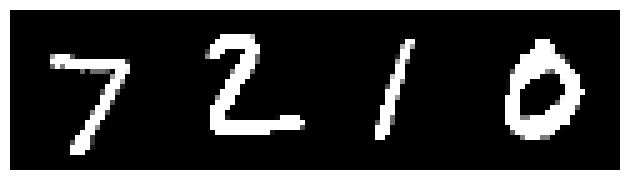

Ground truth:  7 2 1 0
Output logit shape (Num predictions x Batch) x Classes:  torch.Size([64, 10])
Predicted digits:  7 2 1 0
Std. dev. of the scores over the posterior samples 0.000 0.001 0.000 0.065


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from einops import rearrange


def imshow(img) -> None:
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.tight_layout()
    plt.show()


images, labels = next(iter(datamodule.val_dataloader()))

# print images
imshow(torchvision.utils.make_grid(images[:4, ...]))
print("Ground truth: ", " ".join(f"{labels[j]}" for j in range(4)))

# Put the model in eval mode to use several samples
model = routine.eval()
logits = routine(images[:4, ...])
print("Output logit shape (Num predictions x Batch) x Classes: ", logits.shape)
logits = rearrange(logits, "(m b) c -> b m c", b=4)  # batch_size, num_estimators, num_classes

# We apply the softmax on the classes then average over the estimators
probs = torch.nn.functional.softmax(logits, dim=-1)
avg_probs = probs.mean(dim=1)
var_probs = probs.std(dim=1)

predicted = torch.argmax(avg_probs, -1)

print("Predicted digits: ", " ".join(f"{predicted[j]}" for j in range(4)))
print(
    "Std. dev. of the scores over the posterior samples",
    " ".join(f"{var_probs[j][predicted[j]]:.3f}" for j in range(4)),
)

Here, we show the variance of the top prediction. This is a non-standard but intuitive way to show the diversity of the predictions
of the ensemble. Ideally, the variance should be high when the prediction is incorrect.

## References

- **LeNet & MNIST:** LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. [Proceedings of the IEEE](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf).
- **Bayesian Neural Networks:** Blundell, C., Cornebise, J., Kavukcuoglu, K., & Wierstra, D. (2015). Weight Uncertainty in Neural Networks. [ICML 2015](https://arxiv.org/pdf/1505.05424.pdf).
- **The Adam optimizer:** Kingma, D. P., & Ba, J. (2014). "Adam: A method for stochastic optimization." [ICLR 2015](https://arxiv.org/pdf/1412.6980.pdf).
- **The Blitz** [library](https://github.com/piEsposito/blitz-bayesian-deep-learning) (for the hyperparameters).

